$\newcommand{\TirName}[1]{\text{#1}}
\newcommand{\inferrule}[3][]{
  \let\and\qquad
  \begin{array}{@{}l@{}}
  \TirName{#1}
  \\
  \displaystyle
  \frac{#2}{#3}
  \end{array}
}
\newcommand{\infer}[3][]{\inferrule[#1]{#2}{#3}}
$

# Meeting 08 - Abstract Syntax and Parsing

Bor-Yuh Evan Chang  
Thursday, September 19, 2024

<!-- 3 Expressions -->

<!-- 4 Binding and Scope -->

<!-- 8 Recursion -->

<!-- 9 Inductive Data Types -->

<!-- 11 Concrete Syntax -->

<!-- 12 Abstract Syntax and Parsing -->

<!-- 13 Exercise: Syntax -->

<!-- 14 Static Scoping -->

<!-- 15 Judgments -->

<!-- 16 Variables, Basic Values, and Judgments Lab -->

<!-- 18 Operational Semantics -->

<!-- 19 Functions and Dynamic Scoping -->

<!-- 20 Big-Step Exercise -->

<!-- 21 Evaluation Order  -->

<!-- Static Typing -->

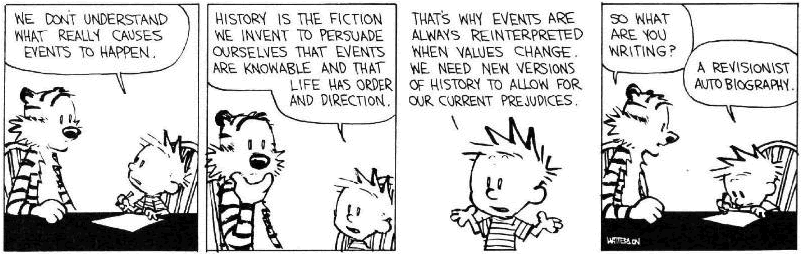

What questions does your neighbor have?

[ In-Class Slides](in-class/meeting08-abstract-syntax.pdf)<br/> [
In-Class Jupyter](in-class/meeting08-abstract-syntax.ipynb)<br/> [ Book
Chapter](https://csci3155.cs.colorado.edu/pppl-course/book/abstract-syntax.html)

## Announcements

-   HW 2 due this ~~Friday~~ Monday 9/23 6pm

## Today

-   Revisit last bit of Concrete Syntax
-   [Abstract
    Syntax](https://csci3155.cs.colorado.edu/pppl-course/book/abstract-syntax.html)
-   Triage Your Questions
    -   Using VSCode or the terminal to test your code (on
        coding.csel.io)?
    -   Auto-testing with GitHub Actions?
    -   Lab 1?
-   Revisit and Go Deeper On:
    -   Concrete Syntax (Meeting 07), if time permits

## Questions?

-   Review:
    -   How do you show that a *grammar* is *ambiguous*?

## Questions?

## One-Slide Review

Concrete syntax is …

Abstract syntax is …

Parsers convert …, which have deal with …

… and … are ways to to describe and deal with a common form of
ambiguity.

Concrete syntax is the surface structure of a language (=strings).

Abstract syntax is the deep structure of a language (=trees/terms).

Parsers convert concrete syntax into abstract syntax, which have deal
with ambiguity.

Precedence and associativity are ways to describe and deal with a common
form of ambiguity.

### Motivation

-   We’ve seen pitfalls when writing grammars.
-   Parser makes life easier down the road in the rest of the tool.
    We’ve seen it is hard enough to recognize tree structure by itself.

## An Ambiguous Grammar

$$\begin{array}{rrrl} \text{expressions} & e & \mathrel{::=}& n \mid e\;\texttt{/}\;e \mid e\;\texttt{-}\;e \end{array}$$

## A Related Unambiguous Grammar

$$\begin{array}{rrrl}
\text{expressions $\texttt{Expr}$} & e & \mathrel{::=}&
  \texttt{N(} n \texttt{)} \\
  & & \mid& \texttt{Divide(}e_1\texttt{,}\;e_2\texttt{)} \\
  & & \mid& \texttt{Minus(}e_1\texttt{,}\;e_2\texttt{)} \\
\text{integers} & n
\end{array}$$

Try hard to read this as concrete syntax. It is unambiguous, right? Why?

## Abstract Syntax Trees

``` scala
sealed trait Expr                                  // e ::=
case class N(n: Int) extends Expr                  //   n
case class Divide(e1: Expr, e2: Expr) extends Expr // | e1 / e2
case class Minus(e1: Expr, e2: Expr) extends Expr  // | e1 - e2
```

It matches the ambiguous grammar when read as concrete syntax. But it is
also standard to write such a grammar and read it (or expect the reader
to read it) as abstract syntax.

## Abstract Syntax Trees

``` scala
Minus(N(10), Divide(N(10), N(10)))
```

## Abstract Syntax Trees versus Parse Trees

# Parsing

Take a Theory of Computation course for more language theory. We focus
here on the practical aspect of reading and writing BNF grammars.

There are also many advanced parser libraries and generator tools. You
might use one in a Compiler Construction course.

## An Ambiguous Grammar

$$
\begin{array}{rrrl}
\text{expressions} & e & \mathrel{::=}& n \mid e + e \\
\text{numbers} &  n
\end{array}
$$

In [2]:
sealed trait Expr                                // e ::=
case class N(n: Double) extends Expr             //   n
case class Plus(e1: Expr, e2: Expr) extends Expr // | e1 + e2

defined trait Expr 
defined class N 
defined class Plus

## Recursive-Descent Parsing

Automate the top-down, *leftmost parsing derivation*.

**Ask:** What’s that?

And trying productions left-to-right until finding a prefix match.

## Recursive-Descent Parsing

Two rules:

1.  Best to have an unambiguous grammar.

Why? Predictability.

1.  No left-recursion in the grammar.

Why? Avoid unbounded “lookahead”.

## Combinator Parsing

In [3]:
import $ivy.`org.scala-lang.modules::scala-parser-combinators:2.4.0`

import $ivy.$

What’s a *combinator*?

A higher-order function/method.

So a combinator parsing library is simply one where you use it by
calling methods with your own callback functions

We’ve seen a higher-order function/method before, right? Yes,

``` scala
List(1, 2, 3).foreach { i => println(i) }
```

    1
    2
    3

## Restricting the Concrete Syntax

$$\begin{array}{rrrl}
  \text{terms} & t, \mathit{term} & \mathrel{::=}& \mathit{num} \mid\texttt{(}\; \mathit{expr} \;\texttt{)} \\
  \text{expressions} & e, \mathit{expr} & \mathrel{::=}& \mathit{term} \mathbin{\texttt{+}} \mathit{term} \\
  \text{numbers} & n, \mathit{num} 
\end{array}$$

Not ambiguous. No left recursion.

These are s-expressions!

## Let’s Implement a Parser!

In [5]:
object ExprParser extends scala.util.parsing.combinator.RegexParsers {
  def num: Parser[String] =
    """-?(\d+(\.\d*)?|\d*\.\d+)([eE][+-]?\d+)?""".r
}

defined object ExprParser

``` scala
object AParser extends scala.util.parsing.combinator.RegexParsers {
  def term: Parser[String] =
    num |
    "(" ~ expr ~ ")" ^^ { case l ~ e ~ r => l + e + r }

  def expr: Parser[String] =
    term ~ "+" ~ term ^^ { case e1 ~ plus ~ e2 => e1 + plus + e2 }

  def num: Parser[String] =
    """-?(\d+(\.\d*)?|\d*\.\d+)([eE][+-]?\d+)?""".r
  
  def parse(str: String): Either[String, String] = parseAll(term, str) match {
    case Success(e, _) => Right(e)
    case Failure(msg, _) => Left(s"Failure: $msg")
    case Error(msg, _) => Left(s"Error: $msg")
  }
}
```

<pre>defined <span class="ansi-green-fg">object</span> <span class="ansi-cyan-fg">AParser</span></pre>

``` scala
object ExprParser extends scala.util.parsing.combinator.RegexParsers {
  def term: Parser[Expr] =
    num ^^ { (n: String) => N(n.toDouble) } |
    "(" ~ expr ~ ")" ^^ { case _ ~ e ~ _ => e }

  def expr: Parser[Expr] =
    term ~ "+" ~ term ^^ { case e1 ~ _ ~ e2 => Plus(e1, e2) }

  def num: Parser[String] =
    """-?(\d+(\.\d*)?|\d*\.\d+)([eE][+-]?\d+)?""".r
  
  def parse(str: String): Either[String, Expr] = parseAll(term, str) match {
    case Success(e, _) => Right(e)
    case Failure(msg, _) => Left(s"Failure: $msg")
    case Error(msg, _) => Left(s"Error: $msg")
  }
}
```

<pre>defined <span class="ansi-green-fg">object</span> <span class="ansi-cyan-fg">ExprParser</span></pre>

First, $$
\mathit{num}
$$

Then, `def parse(s: String): Either[String, String]`.

Then, $$
\mathit{term} \mathrel{::=}\mathit{num}
$$

``` scala
AParser.parse("1")
AParser.parse("<should not parse>")
```

<pre><span class="ansi-cyan-fg">res18_0</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Right</span>(value = <span class="ansi-green-fg">"1"</span>)
<span class="ansi-cyan-fg">res18_1</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">String</span>] = <span class="ansi-yellow-fg">Left</span>(
  value = <span class="ansi-green-fg">"Failure: '(' expected but '&lt;' found"</span>
)</pre>

Then, `def parse(s: String): Either[String, Expr]`.

``` scala
ExprParser.parse("1")
ExprParser.parse("<should not parse>")
```

<pre><span class="ansi-cyan-fg">res19_0</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">Expr</span>] = <span class="ansi-yellow-fg">Right</span>(value = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">1.0</span>))
<span class="ansi-cyan-fg">res19_1</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">Expr</span>] = <span class="ansi-yellow-fg">Left</span>(
  value = <span class="ansi-green-fg">"Failure: '(' expected but '&lt;' found"</span>
)</pre>

Then, $$
\mathit{term} \mathrel{::=}\texttt{(}\; \mathit{expr} \;\texttt{)}
$$

$$
\mathit{expr} \mathrel{::=}\mathit{term} \mathbin{\texttt{+}} \mathit{term}
$$

``` scala
ExprParser.parse("((1 + 2) + 3)")
ExprParser.parse("(1 + (2 + 3))")
```

<pre><span class="ansi-cyan-fg">res20_0</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">Expr</span>] = <span class="ansi-yellow-fg">Right</span>(
  value = <span class="ansi-yellow-fg">Plus</span>(e1 = <span class="ansi-yellow-fg">Plus</span>(e1 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">1.0</span>), e2 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">2.0</span>)), e2 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">3.0</span>))
)
<span class="ansi-cyan-fg">res20_1</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">Expr</span>] = <span class="ansi-yellow-fg">Right</span>(
  value = <span class="ansi-yellow-fg">Plus</span>(e1 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">1.0</span>), e2 = <span class="ansi-yellow-fg">Plus</span>(e1 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">2.0</span>), e2 = <span class="ansi-yellow-fg">N</span>(n = <span class="ansi-green-fg">3.0</span>)))
)</pre>

``` scala
ExprParser.parse("1 + 2 + 3")
```

<pre><span class="ansi-cyan-fg">res21</span>: <span class="ansi-green-fg">Either</span>[<span class="ansi-green-fg">String</span>, <span class="ansi-green-fg">Expr</span>] = <span class="ansi-yellow-fg">Left</span>(value = <span class="ansi-green-fg">"Failure: end of input expected"</span>)</pre>